Updating V4 to actually use the proper E2C code

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import numpy as np
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation, FFMpegWriter
import gymnasium as gym
from PIL import Image

import sys
sys.path.append("..")
from models import ImageDataset, ImageDatasetV2
os.environ["DISPLAY"] = "99"

In [2]:
random_seed = 42  # You can choose any integer for reproducibility
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

device_index = 2
DEVICE = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
env_name = "CartPole-v1-unfixed-10k"
# env_name = "Reacher-v5"
# env_name = "CartPole-v1-unfixed"
# env_name = "cartpole-v1-unfixed-sequence"
# env_name = "cartpole-v1-unfixed-lores"

data_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)) + "/data/" + env_name.lower()
ds = ImageDatasetV2(acts_txt=data_path + "/actions.txt", image_dir=data_path)
train_size = int(0.8 * len(ds))
val_size = len(ds) - train_size
# train_dataset, val_dataset = random_split(ds, [train_size, val_size])
train_dataset = ImageDatasetV2(acts_txt=data_path + "/actions.txt", image_dir=data_path,
                             index=np.arange(0, train_size))
val_dataset = ImageDatasetV2(acts_txt=data_path + "/actions.txt", image_dir=data_path,
                           index=np.arange(train_size, len(ds)))

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, drop_last=True)

In [3]:
print(len(train_dataset.acts))
print(len(train_dataset.curr_image))
print(len(train_dataset.next_image))

7302
14604
7302


In [6]:
for i, data in enumerate(train_loader):
    pass

for i in range(len(train_loader)):
    assert len(train_loader.dataset[i]["imgs_curr"]) == 2, f"{i}th batch imgs_curr length mismatch"
    assert len(train_loader.dataset[i]["imgs_next"]) == 1, f"{i}th batch imgs_next length mismatch"
    assert len(train_loader.dataset[i]["acts"]) == 1, f"{i}th batch acts length mismatch"

In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, input_channels=3, img_size=64, latent_dim=512, batch_size=32):
        super(EncoderCNN, self).__init__()
        self.input_channels = input_channels
        self.batch_size = batch_size

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=5, stride=1, padding=2),  # Output: (32, 64, 64)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), # Output: (32, 8, 8)
            nn.ReLU(),
        )

        # Compute the flattened size after convolutions
        self.enc_fc_shape = self._compute_conv_output_dim(img_size)  # Output dimension after conv layers
        self.fc_input_dim = self.enc_fc_shape[1] * self.enc_fc_shape[2] * self.enc_fc_shape[3]

        self.fc_layers = nn.Sequential(
            nn.Linear(self.fc_input_dim, 512),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(512, latent_dim),  # Final latent representation
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Apply convolutional layers
        x = x.flatten(start_dim=1)  # Flatten to (batch_size, self.fc_dim)
        x = self.fc_layers(x)  # Apply fully connected layers
        return x  # Latent representation
    
    def _compute_conv_output_dim(self, input_dim):
        '''
        Compute output dimension after conv layers given input dimension 
        (assuming square input, i.e, an image of 3 x 64 x 64 would have input_dim = 64)'''
        with torch.no_grad():
            if isinstance(input_dim, tuple):
                x = torch.zeros(self.batch_size, self.input_channels, *input_dim)
            else:
                x = torch.zeros(self.batch_size, self.input_channels, input_dim, input_dim)
            x = self.conv_layers(x)
            return x.shape

class DecoderCNN(nn.Module):
    def __init__(self, latent_dim=512, enc_fc_shape=[32, 128, 128], output_channels=3):
        super(DecoderCNN, self).__init__()

        self.enc_fc_shape = enc_fc_shape
        self.enc_fc_dim = self.enc_fc_shape[1] * self.enc_fc_shape[2] * self.enc_fc_shape[3]
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.enc_fc_dim),  # Reshape to (32, 8, 8)
            nn.ReLU()
        )

        # self.deconv_layers = nn.Sequential(
        #     nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample to (32, 16, 16)
        #     nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),  
        #     nn.ReLU(),

        #     nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample to (32, 32, 32)
        #     nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),  
        #     nn.ReLU(),

        #     nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample to (32, 64, 64)
        #     nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),  
        #     nn.ReLU(),

        #     nn.Conv2d(32, output_channels, kernel_size=5, stride=1, padding=2),  # Final RGB output
        #     nn.Sigmoid()  # Normalize pixel values between 0 and 1
        # )
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1),  # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, output_channels, kernel_size=3, stride=1, padding=1),  # Final RGB output (3, 64, 64)
            nn.Sigmoid()  # Normalize pixel values between 0 and 1
        )

    def forward(self, z):
        x = self.fc_layers(z)
        x = x.view(x.size(0), *self.enc_fc_shape[1:])  # Reshape into (batch, 32, 8, 8)
        x = self.deconv_layers(x)  # Upsample and apply convolutions
        return x  # Reconstructed image

In [ ]:
class Embed2Control(nn.Module):
    def __init__(self, in_channels, enc_zdim, action_dim, latent_dim, past_length=2, pred_length=1, input_dim=64, batch_size=32):
        super(Embed2Control, self).__init__()
        self.encoder = EncoderCNN(input_channels=in_channels, img_size=input_dim, latent_dim=enc_zdim, batch_size=batch_size)
        self.decoder = DecoderCNN(latent_dim, self.encoder.enc_fc_shape, output_channels=in_channels)
        self.action_dim = action_dim
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.past_length = past_length
        self.pred_length = pred_length
        self.enc_zdim = enc_zdim

        self.enc_to_mu = nn.Linear(self.enc_zdim, latent_dim)
        self.enc_to_logvar = nn.Linear(self.enc_zdim, latent_dim)

        # transition network
        self.transition = nn.Sequential(
            nn.Linear(self.latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 32)
        )

        self.trans_to_v = nn.Linear(32, latent_dim)
        self.trans_to_r = nn.Linear(32, latent_dim) # note, A = I + v*r.T
        self.trans_to_B = nn.Linear(32, latent_dim * action_dim)
        self.trans_to_o = nn.Sequential(nn.Linear(32, latent_dim), nn.Tanh())
        self.trans_to_H = nn.Sequential(
            nn.Linear(32, latent_dim), # diagonal matrix
            # nn.Tanh(), # network hacking
        )
        # mean: Az + Bu + o
        # var: A @ enc_to_logvar (exp(diagonalize output)) @ A.T + H
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        std = torch.clamp(std, min=1e-5, max=1e5)  # Ensure std is not too small to avoid numerical issues
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_past, x_future, actions):
        """
        Forward pass through the Embed2Control model.
        
        Args:
            x_past (Tensor): Past images of shape (batch_size, past_length, C, H, W)
            x_future (Tensor): Futures images of shape (batch_size, past_length, C, H, W)
            actions (Tensor): Actions of shape (batch_size, pred_length, action_dim)
        
        Returns:
            mu_t, logvar_t, z_t: Latent representation of current state.
            img_hat_t: Reconstruction of current observation.
            mu_t_next, logvar_t_next: Next latent state distribution.
            z_hat_t_next: Predicted next latent distribution.
            img_hat_t_next: Predicted next image.
        """
        batch_size = x_past.shape[0]
        # x_past_flat = x_past.reshape(batch_size, self.past_length * 3, self.input_dim, self.input_dim)
        x_past_flat = x_past.reshape(batch_size, self.past_length * 3, *self.input_dim) if isinstance(self.input_dim, tuple) else x_past.reshape(batch_size, self.past_length * 3, self.input_dim, self.input_dim)
        enc_output = self.encoder(x_past_flat)  # Shape: (batch_size * past_length, enc_zdim)        

        # Compute latent mean and log variance
        mu_t = self.enc_to_mu(enc_output)  # (batch_size, latent_dim)
        logvar_t = self.enc_to_logvar(enc_output)  # (batch_size, latent_dim)
        z_t = self.reparametrize(mu_t, logvar_t)  # (batch_size, latent_dim)
        img_hat_t = self.decoder(z_t)  # (batch_size, self.past_length * 3, input_dim, input_dim)
        img_hat_t = img_hat_t.reshape(batch_size, self.past_length, 3, *self.input_dim) if isinstance(self.input_dim, tuple) else img_hat_t.reshape(batch_size, self.past_length, 3, self.input_dim, self.input_dim)  # Reshape to (batch_size, past_length, 3, input_dim, input_dim)

        # Transition model: Predict next latent state
        trans_input = self.transition(z_t)
        v = self.trans_to_v(trans_input).unsqueeze(-1)
        r = self.trans_to_r(trans_input).unsqueeze(-1)
        # A = torch.eye(self.latent_dim).unsqueeze(0).repeat(batch_size, 1, 1) + torch.bmm(v, r.T)
        A = torch.eye(self.latent_dim, device=DEVICE).repeat(batch_size, 1, 1) + torch.bmm(v, r.permute(0, 2, 1))
        B = self.trans_to_B(trans_input).view(batch_size, self.latent_dim, self.action_dim)
        o = self.trans_to_o(trans_input) # batch_size, latent_dim
        H = torch.diag_embed(self.trans_to_H(trans_input)) # batch_size, latent_dim, latent_dim
        C = torch.bmm(torch.bmm(A, torch.diag_embed(torch.exp(logvar_t))), A.permute(0, 2, 1)) + H

        # Compute next state prediction: ẑ_t+1 = A_t * z_t + B_t * u_t + o_t
        # compute predicted z_hat
        # print("A", A.shape)
        # print("zt", z_t.unsqueeze(-1).shape)
        # print("B", B.shape)
        # print("actions", actions.shape)
        # print("actions", actions.permute(0, 2, 1).shape)
        # print("o", o.shape)
        # print(torch.bmm(A, z_t.unsqueeze(-1)).shape)
        # print(torch.bmm(B, actions.permute(0, 2, 1)).shape)
        # print("C", C.shape)
        mu_hat_next_trans = (torch.bmm(A, z_t.unsqueeze(-1)) + torch.bmm(B, actions.permute(0, 2, 1))).squeeze(-1) + o
        logvar_next_trans = torch.diagonal(C, dim1=-2, dim2=-1)
        # logvar_next_trans = torch.log(torch.diagonal(C, dim1=-2, dim2=-1))
        # print("mu_hat_next_trans", mu_hat_next_trans)
        # print("logvar_next_trans", logvar_next_trans)
        z_hat_next_trans = self.reparametrize(mu_hat_next_trans, logvar_next_trans)
        # img_hat_next_trans = self.decoder(z_hat_next_trans)
        
        enc_future = self.encoder(x_future.reshape(batch_size, self.past_length * 3, *self.input_dim) if isinstance(self.input_dim, tuple) else x_future.reshape(batch_size, self.past_length * 3, self.input_dim, self.input_dim))  # Use x_t+1 for encoding
        mu_t_next = self.enc_to_mu(enc_future)  # (batch_size, latent_dim)
        logvar_t_next = self.enc_to_logvar(enc_future)  # (batch_size, latent_dim)
        z_t_next = self.reparametrize(mu_t_next, logvar_t_next)
        img_hat_t_next = self.decoder(z_t_next)  # (batch_size, 3, input_dim, input_dim)
        img_hat_t_next = img_hat_t_next.reshape(batch_size, self.past_length, 3, *self.input_dim) if isinstance(self.input_dim, tuple) else img_hat_t_next.reshape(batch_size, self.past_length, 3, self.input_dim, self.input_dim)  # Reshape to (batch_size, past_length, 3, input_dim, input_dim)

        return mu_t, logvar_t, z_t, img_hat_t, mu_t_next, logvar_t_next, z_t_next, img_hat_t_next, z_hat_next_trans

In [62]:
def compute_loss(
        mu_t, logvar_t, img_t, img_hat_t,
        mu_t_next, logvar_t_next, img_hat_t_next, img_t_next, q_psi_trans,
        lambda_kl=1.0, lambda_recon=1.0,
        ):
    """Computes the Embed-to-Control loss function.

    Args:
    - mu_t, logvar_t: Mean and log variance of the latent distribution Q_phi(z_t | x_t) - encoded past images (batch_size, past_length, latent_dim)
    - img_hat_t: Reconstruction log prob P_theta(x_t | z_t) - reconstructed image from decoder (batch_size, past_length, 3, input_dim, input_dim)
    - img_t: Real past images (batch_size, past_length, 3, input_dim, input_dim)
    - img_hat_t_next: Prediction log prob P_theta(x_t+1 | z_hat_t+1) - reconstructed next image from dyn prediction of z_t+1 (batch_size, pred_length, 3, input_dim, input_dim)
    - img_t_next: Real next images (batch_size, pred_length, 3, input_dim, input_dim)
    - mu_t_next, logvar_t_next: Mean and log variance of the next latent distribution Q_phi(z_t+1 | x_t+1) - encoded next images (batch_size, pred_length, latent_dim)
    - q_psi_trans: Transition model Q_psi(z_hat_t+1 | mu_t, u_t) - 
    - lambda_kl: Weight for the KL regularization term

    Returns:
    - Total loss
    """

    # 1. Sample z_t using the reparameterization trick
    # Current images, encoded
    std_t = torch.exp(0.5 * logvar_t)
    eps = torch.randn_like(std_t)
    z_t = mu_t + std_t * eps

    # 2. Sample z_t+1 from the next latent distribution
    # Next images, encoded
    std_t_next = torch.exp(0.5 * logvar_t_next)
    eps_next = torch.randn_like(std_t_next)
    z_t_next = mu_t_next + std_t_next * eps_next

    # 3. Reconstruction loss (MSE between real and reconstructed images) (can be log likelihood)
    recon_loss_t = F.mse_loss(img_hat_t, img_t, reduction="mean")
    recon_loss_t_next = F.mse_loss(img_hat_t_next, img_t_next, reduction="mean")
    recon_loss = lambda_recon * (recon_loss_t + recon_loss_t_next)

    # 4. KL divergence between encoder output and prior (zero-mean Gaussian)
    kl_loss = -0.5 * torch.sum(1 + logvar_t - mu_t.pow(2) - logvar_t.exp(), dim=-1).mean()

    # 5. KL divergence between transition model prediction and true next latent
    kl_trans = -0.5 * torch.sum(1 + logvar_t_next - (q_psi_trans - mu_t_next).pow(2) - logvar_t_next.exp(), dim=-1).mean()

    # Final loss
    loss = recon_loss + lambda_kl * (kl_loss + kl_trans)
    return loss, recon_loss.item(), lambda_kl * (kl_loss + kl_trans).item()


In [63]:
pred_length = 1
past_length = 2
act_dim = 1
IMG_SIZE = (train_loader.dataset[0]['imgs_next'][0].shape[1], train_loader.dataset[0]['imgs_next'][0].shape[2])
Z_DIM = 256
N_EPOCHS = 10
latent_dim = 4

model = Embed2Control(
    in_channels=past_length * 3,
    enc_zdim=Z_DIM,
    action_dim=act_dim,
    latent_dim=latent_dim,
    past_length=past_length,
    pred_length=pred_length,
    input_dim=IMG_SIZE,
    batch_size=BATCH_SIZE
).to(DEVICE)

L_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=L_RATE, weight_decay=1e-4)
loss_func = nn.BCELoss(reduction="mean")

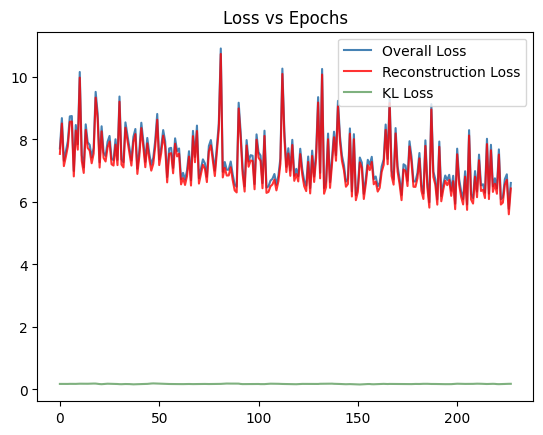

Epoch 9 | Loss: 6.4274 | KL Loss: 0.1773: 100%|██████████| 10/10 [00:55<00:00,  5.50s/it]


In [ ]:
lambda_recon = 1e4
lambda_kl = 5e-3
all_epochs = tqdm(range(N_EPOCHS))

for epoch in all_epochs:
    rec_loss_arr = []
    kl_trans = []
    kl_loss_arr = []
    overall_loss = []

    for obs_counter, sample in enumerate(train_loader):
        x_past = sample['imgs_curr'].to(DEVICE)
        x_future = torch.hstack([sample['imgs_next'], sample['imgs_next']]).to(DEVICE)
        acts = sample['acts'].to(DEVICE)

        mu_t, logvar_t, z_hat_t, img_hat_t, \
        mu_t_next, logvar_t_next, z_hat_t_next, img_hat_t_next, \
        z_hat_next_trans = model(x_past, x_future, acts)
        # print("mu_t", mu_t)
        # print("logvar_t", logvar_t)
        # print("z_hat_t", z_hat_t)
        # print("mu_t_next", mu_t_next)
        # print("logvar_t_next", logvar_t_next)
        # print("z_hat_t_next", z_hat_t_next)
        # print("z_hat_next_trans", z_hat_next_trans)

        # Compute loss
        loss, rec_loss, kl_loss = compute_loss(
            mu_t, logvar_t, x_past, img_hat_t,
            mu_t_next, logvar_t_next, x_future, img_hat_t_next,
            z_hat_next_trans, lambda_kl=lambda_kl * (epoch+1)/N_EPOCHS, lambda_recon=lambda_recon
        )
        
        loss.backward()
        optimizer.step()
        
        overall_loss.append(loss.item())
        rec_loss_arr.append(rec_loss)
        kl_loss_arr.append(kl_loss)

        optimizer.zero_grad()
        all_epochs.set_description(f"Epoch {epoch} | Loss: {rec_loss:.4f} | KL Loss: {kl_loss:.4f}")
        if torch.isnan(loss):
            print("NaN loss encountered, stopping training.")
            break

    clear_output(wait=True)

    plt.plot(overall_loss, c="steelblue", label="Overall Loss")
    plt.plot(rec_loss_arr, c="red", label="Reconstruction Loss", alpha=0.8)
    plt.plot(kl_loss_arr, c="darkgreen", label="KL Loss", alpha=0.5)
    plt.legend()
    plt.title("Loss vs Epochs")
    plt.show()
    

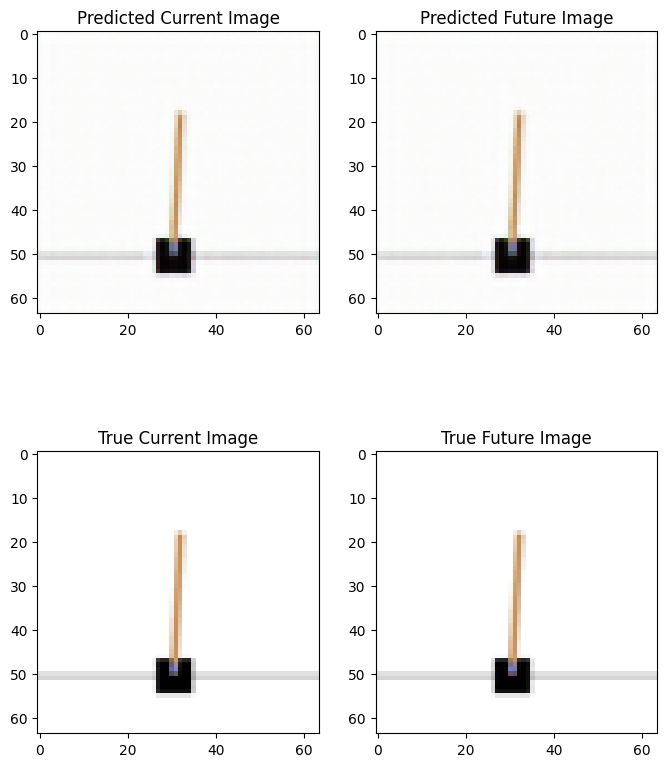

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(8, 10))
ax[0, 0].set_title("Predicted Current Image")
ax[1, 0].set_title("True Current Image")
ax[0, 1].set_title("Predicted Future Image")
ax[1, 1].set_title("True Future Image")

ax[0, 0].imshow(img_hat_t[0][0].permute(1, 2, 0).cpu().detach().numpy())
ax[1, 0].imshow(x_past[0][0].permute(1, 2, 0).cpu().detach().numpy())
ax[0, 1].imshow(img_hat_t_next[0][0].permute(1, 2, 0).cpu().detach().numpy())
ax[1, 1].imshow(x_future[0][0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

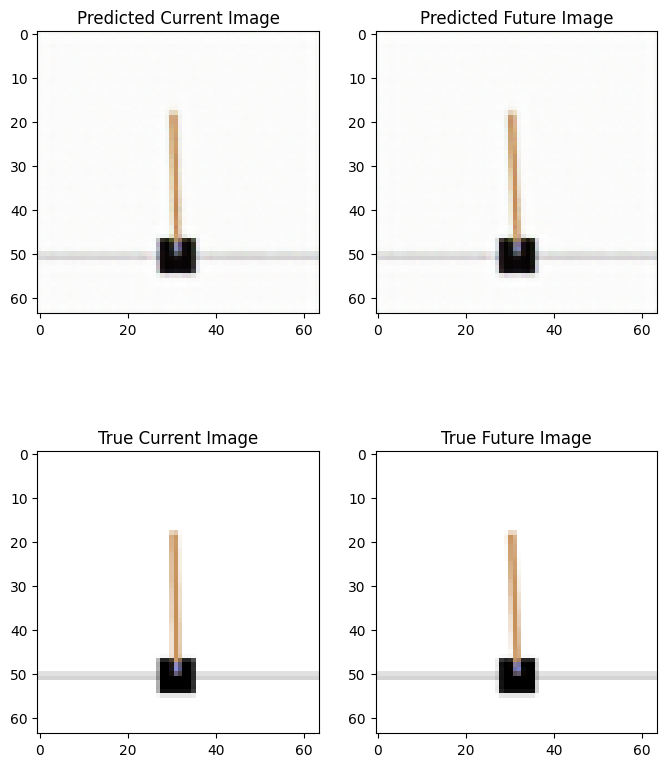

In [68]:
model.eval()

fig, ax = plt.subplots(2, 2, figsize=(8, 10))
ax[0, 0].set_title("Predicted Current Image")
ax[1, 0].set_title("True Current Image")
ax[0, 1].set_title("Predicted Future Image")
ax[1, 1].set_title("True Future Image")

def update_plot(frame):
    add_some = 15
    for i, sample in enumerate(val_loader):
        x_past = sample['imgs_curr'].to(DEVICE)
        x_future = torch.hstack([sample['imgs_next'], sample['imgs_next']]).to(DEVICE)
        acts = sample['acts'].to(DEVICE)
        if i == add_some + frame:
            break

    mu_t, logvar_t, z_hat_t, img_hat_t, \
    mu_t_next, logvar_t_next, z_hat_t_next, img_hat_t_next, \
    z_hat_next_trans = model(x_past, x_future, acts)
    
    for i in range(pred_length):
        ax[0, 0].imshow(img_hat_t[0][i].view(3, *IMG_SIZE).permute(1, 2, 0).detach().cpu().numpy())
        ax[1, 0].imshow(x_past[0][i].permute(1, 2, 0).detach().cpu().numpy())
        ax[0, 1].imshow(img_hat_t_next[0][i].view(3, *IMG_SIZE).permute(1, 2, 0).detach().cpu().numpy())
        ax[1, 1].imshow(x_future[0][i].permute(1, 2, 0).detach().cpu().numpy())

    plt.show()


ani = FuncAnimation(fig, update_plot, frames=50, interval=5.)
writer = FFMpegWriter(fps=2)
ani.save('videos/e2c_10k_test.mp4', writer=writer)

0.0 0.0 1.0 1.0 1.0


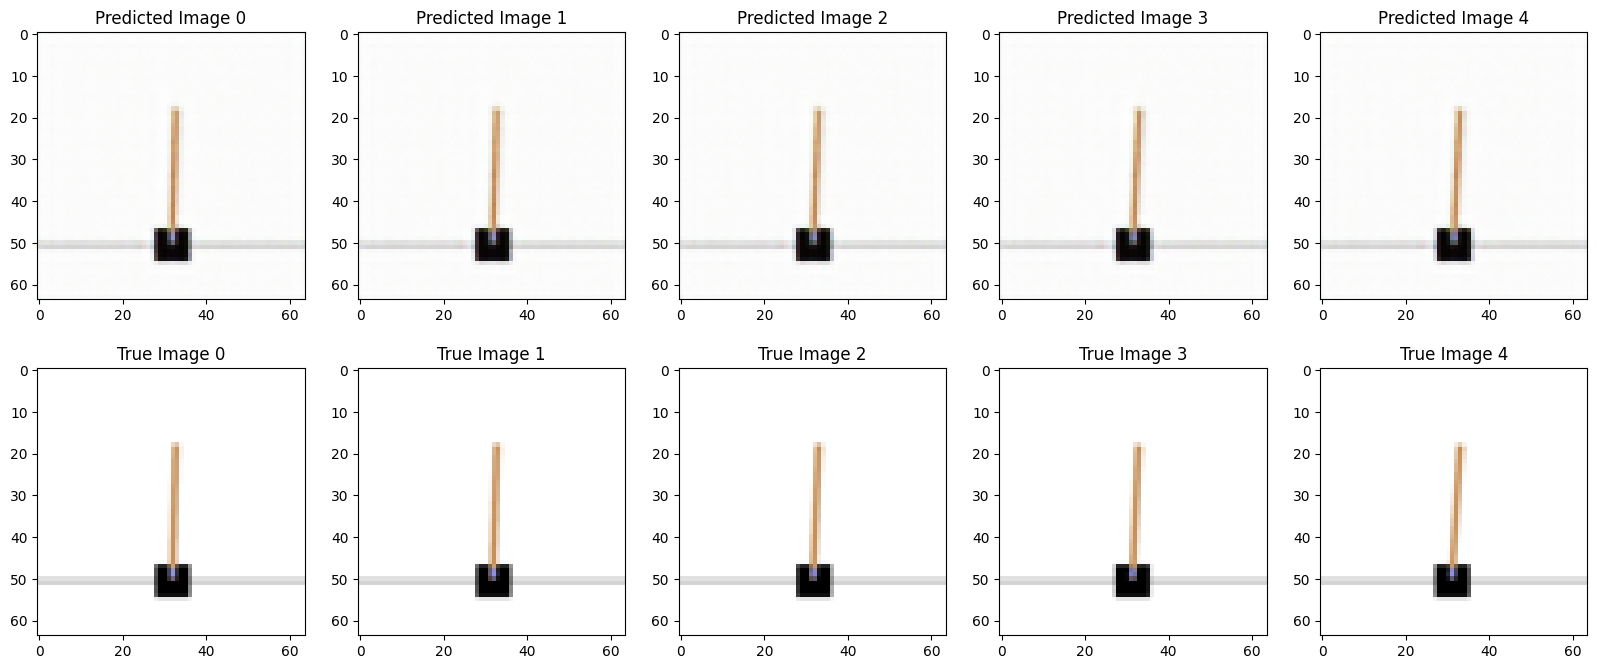

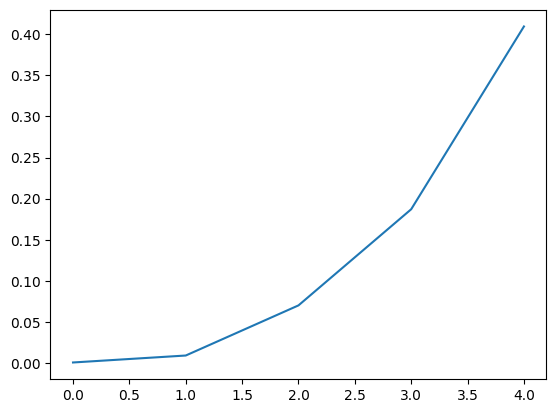

In [116]:
# Generate a sequence of 10 forward trajectories
model.eval()
t_forward = 5
actions = torch.zeros((1, 5, 1), device=DEVICE).float()

fig, ax = plt.subplots(2, t_forward, figsize=(20, 8))
x0_ind = 50
print(*[train_loader.dataset[x0_ind+t_f]["acts"].item() for t_f in range(t_forward)])
x0 = train_loader.dataset[x0_ind]["imgs_curr"].to(DEVICE)
z_diff = []

x_true = torch.as_tensor(train_loader.dataset[x0_ind]["imgs_curr"], dtype=torch.float32, device=DEVICE).unsqueeze(0)
for a in range(t_forward):
    x_goal = train_loader.dataset[x0_ind + a-1]["imgs_next"]
    x_goal = torch.hstack([x_goal, x_goal]).to(DEVICE)  # make it past_length long
    z_goal = model.enc_to_mu(model.encoder(x_goal)) #.view(1, 3, IMG_SIZE, IMG_SIZE)))
    enc_output = model.encoder(x0.reshape(1, past_length * 3, *IMG_SIZE) if isinstance(IMG_SIZE, tuple) else x0.reshape(1, past_length * 3, IMG_SIZE, IMG_SIZE))  # Shape: (1 * past_length, enc_zdim)
    mu_t = model.enc_to_mu(enc_output)  # (batch_size, latent_dim)
    logvar_t = model.enc_to_logvar(enc_output)  # (batch_size, latent_dim)
    z_t = model.reparametrize(mu_t, logvar_t)  # (batch_size, latent_dim)
    z_diff.append((torch.norm(z_t - z_goal, p=2) ** 2).detach().cpu().numpy())
    img_hat_t = model.decoder(z_t)  # (batch_size, self.past_length * 3, input_dim, input_dim)
    img_hat_t = img_hat_t.reshape(1, model.past_length, 3, *model.input_dim) if isinstance(model.input_dim, tuple) else img_hat_t.reshape(1, model.past_length, 3, model.input_dim, model.input_dim)  # Reshape to (batch_size, past_length, 3, input_dim, input_dim)
    trans_input = model.transition(z_t)
    v = model.trans_to_v(trans_input).unsqueeze(-1)
    r = model.trans_to_r(trans_input).unsqueeze(-1)
    # A = torch.eye(self.latent_dim).unsqueeze(0).repeat(batch_size, 1, 1) + torch.bmm(v, r.T)
    A = torch.eye(model.latent_dim, device=DEVICE).repeat(1, 1, 1) + torch.bmm(v, r.permute(0, 2, 1))
    B = model.trans_to_B(trans_input).view(1, model.latent_dim, model.action_dim)
    o = model.trans_to_o(trans_input) # batch_size, latent_dim
    H = torch.diag_embed(model.trans_to_H(trans_input)) # batch_size, latent_dim, latent_dim
    C = torch.bmm(torch.bmm(A, torch.diag_embed(torch.exp(logvar_t))), A.permute(0, 2, 1)) + H
    # print("A", A.shape)
    # print("zt", z_t.unsqueeze(-1).shape)
    # print("B", B.shape)
    # print("actions", actions[:, a, :].unsqueeze(-1).permute(0, 2, 1).shape)
    # print("o", o.shape)
    # print(torch.bmm(A, z_t.unsqueeze(-1)).shape)
    # print(torch.bmm(B, actions[:, a, :].unsqueeze(-1).permute(0, 2, 1)).shape)
    # print("C", C.shape)
    # mu_hat_next_trans = (torch.bmm(A, z_t.unsqueeze(-1)) + torch.bmm(B, actions[:, a, :].unsqueeze(-1).permute(0, 2, 1))).squeeze(-1) + o
    mu_hat_next_trans = (torch.bmm(A, z_t.unsqueeze(-1)) + torch.bmm(B, train_loader.dataset[x0_ind+a]["acts"].unsqueeze(-1).to(DEVICE))).squeeze(-1) + o
    logvar_next_trans = torch.diagonal(C, dim1=-2, dim2=-1)
    z_hat_next_trans = model.reparametrize(mu_hat_next_trans, logvar_next_trans)
    img_hat_t_next = model.decoder(z_hat_next_trans)  # (batch_size, 3, input_dim, input_dim)
    img_hat_t = img_hat_t_next.reshape(1, model.past_length, 3, *model.input_dim) if isinstance(model.input_dim, tuple) else img_hat_t_next.reshape(1, model.past_length, 3, model.input_dim, model.input_dim)  # Reshape to (batch_size, past_length, 3, input_dim, input_dim)

    ax[0, a].imshow(img_hat_t[0][0].permute(1, 2, 0).detach().cpu().numpy())
    ax[1, a].imshow(x_true[0][0].permute(1, 2, 0).detach().cpu().numpy())
    ax[0, a].set_title(f"Predicted Image {a}")
    ax[1, a].set_title(f"True Image {a}")

    # Compute next state prediction: ẑ_t+1 = A_t * z_t + B_t * u_t + o_t
    x0 = model.decoder(z_hat_next_trans)
    # x0 = train_loader.dataset[x0_ind + a]["imgs_curr"].to(DEVICE)
    x_true = torch.as_tensor(train_loader.dataset[x0_ind + a + 1]["imgs_curr"], dtype=torch.float32, device=DEVICE).unsqueeze(0)

plt.show()
plt.plot(z_diff)
plt.show()

In [ ]:
def ilqr(Q, R, Qf, x0, x_goal, N, max_iter=100, tol=1e-3):
    """
    iLQR for a linear system Ax + Bu + c = x_next
    Where x is the latent state from my model

    Parameters:
    A: State transition matrix
    B: Control input matrix
    c: Constant vector
    Q: State cost matrix
    R: Control cost matrix
    Qf: Final state cost matrix
    x0: Initial state
    x_goal: Goal state
    N: Number of time steps
    max_iter: Maximum number of iterations
    tol: Convergence tolerance

    Returns:
    x_traj: State trajectory
    u_traj: Control trajectory
    """
    model.eval()
    n = model.latent_dim
    m = model.action_dim

    # Initialize trajectories
    x_traj = torch.zeros((N+1, n, 1), device=x0.device)
    u_traj = torch.randint(0, 2, (N, m, 1), device=DEVICE).float()
    x_traj[0] = x0
    A_list = torch.zeros((N, model.latent_dim, model.latent_dim), device=x0.device)
    B_list = torch.zeros((N, model.latent_dim, model.action_dim), device=x0.device)
    o_list = torch.zeros((N, model.latent_dim, 1), device=x0.device)

    for iteration in range(max_iter):
        for i in range(N):
            trans_input = model.transition_network(x_traj[i].T)  # (batch_size, 32)
            A_t = model.trans_to_A(trans_input).view(model.latent_dim, 2)  # (batch_size, latent_dim, 2)
            B_list[i] = model.trans_to_B(trans_input).view(model.latent_dim, model.action_dim)  # (batch_size, latent_dim, action_dim)
            o_list[i] = model.trans_to_o(trans_input).view(model.latent_dim, 1)
            A_t = torch.eye(model.latent_dim, device=x_past.device) + A_t[:, 0].unsqueeze(-1) @ A_t[:, 1].unsqueeze(-1).T
            A_list[i] = A_t.clone()
            x_traj[i+1] = (A_t @ x_traj[i]) + B_t @ u_traj[i] + o_list[i]
        # Backward pass
        V = Qf
        v = (Qf @ (x_traj[-1] - x_goal))
        K = torch.zeros((N, m, n), device=x0.device)
        k = torch.zeros((N, 1, m), device=x0.device)

        for i in range(N-1, -1, -1):
            Qx = Q @ ((x_traj[i] - x_goal)) + A_list[i].T @ v
            Qu = R @ u_traj[i] + B_list[i].T @ v
            Qxx = Q + A_list[i].T @ V @ A_list[i]
            Quu = R + B_list[i].T @ V @ B_list[i]
            Qux = B_list[i].T @ V @ A_list[i]

            K[i] = -torch.linalg.inv(Quu) @ Qux
            k[i] = -torch.linalg.inv(Quu) @ Qu

            v = Qx + K[i].T @ Quu @ k[i] + K[i].T @ Qu + Qux.T @ k[i]
            V = Qxx + K[i].T @ Quu @ K[i] + K[i].T @ Qux + Qux.T @ K[i]

        # Forward pass
        x_new = torch.zeros((N+1, n, 1), device=x0.device)
        u_new = torch.zeros((N, m, 1), device=x0.device)
        x_new[0] = x0

        for i in range(N):
            u_new[i] = u_traj[i] + k[i] + K[i] @ (x_new[i] - x_traj[i])
            x_new[i+1] = (A_list[i] @ x_new[i] + B_list[i] @ u_new[i] + o_list[i])
        
        u_new = torch.clamp(torch.round(u_new), min=0, max=1)

        # Check for convergence
        if torch.max(torch.abs(x_new - x_traj)) < tol:
            break

        x_traj = x_new
        u_traj = u_new

    return x_traj, u_traj

# Example usage
Q = 5 * torch.eye(model.latent_dim, device=DEVICE)
R = 0.1 * torch.eye(model.action_dim, device=DEVICE)
Qf = torch.eye(model.latent_dim, device=DEVICE)
N = 5
x0 = train_img_loader.dataset[x0_ind]
x0 = torch.as_tensor(x0, dtype=torch.float32, device=DEVICE).unsqueeze(0) / 255.
x0 = (model.encoder(x0.view(1, 3, IMG_SIZE, IMG_SIZE))).to(DEVICE)
mu_t = model.enc_to_mu(x0)  # (batch_size, latent_dim)
logvar_t = model.enc_to_logvar(x0)  # (batch_size, latent_dim)
x0 = model.reparametrize(mu_t, logvar_t).to(DEVICE).T

x_goal = train_img_loader.dataset[x0_ind + t_forward]
x_goal = torch.as_tensor(x_goal, dtype=torch.float32, device=DEVICE).unsqueeze(0) / 255.
x_goal = model.encoder(x_goal.view(1, 3, IMG_SIZE, IMG_SIZE))
mu_t = model.enc_to_mu(x_goal)  # (batch_size, latent_dim)
logvar_t = model.enc_to_logvar(x_goal)  # (batch_size, latent_dim)
x_goal = model.reparametrize(mu_t, logvar_t).to(DEVICE).T

x_traj, u_traj = ilqr(Q, R, Qf, x0, x_goal, N, max_iter=10)
# print("State trajectory:\n", x_traj)
# print("Control trajectory:\n", u_traj)
fig, ax = plt.subplots(2, x_traj.shape[0]+1, figsize=(20, 8))
z_diff = []
for i in range(x_traj.shape[0]):
    img_hat_t = model.decoder(x_traj[i].T)
    img_hat_t = img_hat_t.view(3, IMG_SIZE, IMG_SIZE).permute(1, 2, 0).detach().cpu().numpy()
    z_diff.append(np.mean((torch.norm(x_traj[i] - x_goal, p=2) ** 2).detach().cpu().numpy()))
    ax[0, i].imshow(img_hat_t)
    ax[0, i].set_title(f"Predicted Image {i}")
    ax[1, i].imshow((torch.as_tensor(train_img_loader.dataset[x0_ind + i], dtype=torch.float32, device=DEVICE) / 255.).permute(1, 2, 0).detach().cpu().numpy())
    ax[1, i].set_title(f"True Image {i}")
ax[0, -1].plot(z_diff)
ax[0, -1].set_title("Distance from Goal in Latent Space")
ax[0, -1].set_xlabel("Time Step")
ax[0, -1].set_ylabel("L2 Distance")
ax[1, -1].clear()
ax[1, -1].remove()
plt.show()

In [ ]:
pred_length = 1
past_length = 1
act_dim = 1
IMG_SIZE = 64
Z_DIM = 8
enc_zdim = 256
N_EPOCHS = 10
latent_dim = 32

model = Embed2Control(
    in_channels=past_length * 3,
    enc_zdim=Z_DIM,
    action_dim=act_dim,
    latent_dim=latent_dim,
    past_length=past_length,
    pred_length=pred_length,
    input_dim=IMG_SIZE
).to(DEVICE)

L_RATE = 5e-5
optimizer = optim.Adam(model.parameters(), lr=L_RATE, weight_decay=1e-4)
loss_func = nn.BCELoss(reduction="mean")

model.load_state_dict(torch.load(os.path.join(os.getcwd(), os.pardir) + "/chkpts/e2c_v3_l8.pth"))

In [ ]:
chkpt_file = "e2c_v3_l8"
torch.save(model.state_dict(), os.path.join(os.getcwd(), os.pardir) + "/chkpts/" + chkpt_file + ".pth")

In [ ]:
def ilqr(Q, R, Qf, x0, x_goal, N, max_iter=100, tol=1e-3):
    """
    iLQR for a linear system Ax + Bu + c = x_next
    Where x is the latent state from my model

    Parameters:
    A: State transition matrix
    B: Control input matrix
    c: Constant vector
    Q: State cost matrix
    R: Control cost matrix
    Qf: Final state cost matrix
    x0: Initial state
    x_goal: Goal state
    N: Number of time steps
    max_iter: Maximum number of iterations
    tol: Convergence tolerance

    Returns:
    x_traj: State trajectory
    u_traj: Control trajectory
    """
    model.eval()
    n = model.latent_dim
    m = model.action_dim

    # Initialize trajectories
    x_traj = torch.zeros((N+1, n, 1), device=x0.device)
    u_traj = torch.randint(0, 2, (N, m, 1), device=DEVICE).float()
    x_traj[0] = x0
    A_list = torch.zeros((N, model.latent_dim, model.latent_dim), device=x0.device)
    B_list = torch.zeros((N, model.latent_dim, model.action_dim), device=x0.device)
    o_list = torch.zeros((N, model.latent_dim, 1), device=x0.device)

    for iteration in range(max_iter):
        for i in range(N):
            trans_input = model.transition_network(x_traj[i].T)  # (batch_size, 32)
            A_t = model.trans_to_A(trans_input).view(model.latent_dim, 2)  # (batch_size, latent_dim, 2)
            B_list[i] = model.trans_to_B(trans_input).view(model.latent_dim, model.action_dim)  # (batch_size, latent_dim, action_dim)
            o_list[i] = model.trans_to_o(trans_input).view(model.latent_dim, 1)
            A_t = torch.eye(model.latent_dim, device=x_past.device) + A_t[:, 0].unsqueeze(-1) @ A_t[:, 1].unsqueeze(-1).T
            A_list[i] = A_t.clone()
            x_traj[i+1] = (A_t @ x_traj[i]) + B_t @ u_traj[i] + o_list[i]
        # Backward pass
        V = Qf
        v = (Qf @ (x_traj[-1] - x_goal))
        K = torch.zeros((N, m, n), device=x0.device)
        k = torch.zeros((N, 1, m), device=x0.device)

        for i in range(N-1, -1, -1):
            Qx = Q @ ((x_traj[i] - x_goal)) + A_list[i].T @ v
            Qu = R @ u_traj[i] + B_list[i].T @ v
            Qxx = Q + A_list[i].T @ V @ A_list[i]
            Quu = R + B_list[i].T @ V @ B_list[i]
            Qux = B_list[i].T @ V @ A_list[i]

            K[i] = -torch.linalg.inv(Quu) @ Qux
            k[i] = -torch.linalg.inv(Quu) @ Qu

            v = Qx + K[i].T @ Quu @ k[i] + K[i].T @ Qu + Qux.T @ k[i]
            V = Qxx + K[i].T @ Quu @ K[i] + K[i].T @ Qux + Qux.T @ K[i]

        # Forward pass
        x_new = torch.zeros((N+1, n, 1), device=x0.device)
        u_new = torch.zeros((N, m, 1), device=x0.device)
        x_new[0] = x0

        for i in range(N):
            u_new[i] = u_traj[i] + k[i] + K[i] @ (x_new[i] - x_traj[i])
            x_new[i+1] = (A_list[i] @ x_new[i] + B_list[i] @ u_new[i] + o_list[i])
        
        u_new = torch.clamp(torch.round(u_new), min=0, max=1)

        # Check for convergence
        if torch.max(torch.abs(x_new - x_traj)) < tol:
            break

        x_traj = x_new
        u_traj = u_new

    return x_traj, u_traj

# Example usage
Q = 5 * torch.eye(model.latent_dim, device=DEVICE)
R = 0.1 * torch.eye(model.action_dim, device=DEVICE)
Qf = torch.eye(model.latent_dim, device=DEVICE)
N = 5
x0 = train_img_loader.dataset[x0_ind]
x0 = torch.as_tensor(x0, dtype=torch.float32, device=DEVICE).unsqueeze(0) / 255.
x0 = (model.encoder(x0.view(1, 3, IMG_SIZE, IMG_SIZE))).to(DEVICE)
x0 = model.enc_to_mu(x0).to(DEVICE).T
# mu_t = model.enc_to_mu(x0)  # (batch_size, latent_dim)
# logvar_t = model.enc_to_logvar(x0)  # (batch_size, latent_dim)
# x0 = model.reparametrize(mu_t, logvar_t).to(DEVICE).T

x_goal = train_img_loader.dataset[x0_ind + t_forward]
x_goal = torch.as_tensor(x_goal, dtype=torch.float32, device=DEVICE).unsqueeze(0) / 255.
x_goal = model.encoder(x_goal.view(1, 3, IMG_SIZE, IMG_SIZE))
x_goal = model.enc_to_mu(x_goal).to(DEVICE).T
# mu_t = model.enc_to_mu(x_goal)  # (batch_size, latent_dim)
# logvar_t = model.enc_to_logvar(x_goal)  # (batch_size, latent_dim)
# x_goal = model.reparametrize(mu_t, logvar_t).to(DEVICE).T

x_traj, u_traj = ilqr(Q, R, Qf, x0, x_goal, N, max_iter=100)
# print("State trajectory:\n", x_traj)
# print("Control trajectory:\n", u_traj)
fig, ax = plt.subplots(2, x_traj.shape[0]+1, figsize=(20, 8))
z_diff = []
for i in range(x_traj.shape[0]):
    img_hat_t = model.decoder(x_traj[i].T)
    img_hat_t = img_hat_t.view(3, IMG_SIZE, IMG_SIZE).permute(1, 2, 0).detach().cpu().numpy()
    z_diff.append(np.mean((torch.norm(x_traj[i] - x_goal, p=2) ** 2).detach().cpu().numpy()))
    ax[0, i].imshow(img_hat_t)
    ax[0, i].set_title(f"Predicted Image {i}")
    ax[1, i].imshow((torch.as_tensor(train_img_loader.dataset[x0_ind + i], dtype=torch.float32, device=DEVICE) / 255.).permute(1, 2, 0).detach().cpu().numpy())
    ax[1, i].set_title(f"True Image {i}")
ax[0, -1].plot(z_diff)
ax[0, -1].set_title("Distance from Goal in Latent Space")
ax[0, -1].set_xlabel("Time Step")
ax[0, -1].set_ylabel("L2 Distance")
ax[1, -1].clear()
ax[1, -1].remove()
plt.show()